In [1]:
# https://www.kaggle.com/artgor/molecular-properties-eda-and-models

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx


alt.renderers.enable('notebook')
import artgor_utils


In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/sample_submission.csv')
structures = pd.read_csv('../data/structures.csv')

In [4]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0        84.807599999999994  
1       -11.257000000000000  
2       -11.254799999999999  
3       -11.254300000000001  
4        84.807400000000001

In [5]:
structures.head(15)

molecule_name  atom_index atom             x             y  \
0   dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580   
1   dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176   
2   dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620   
3   dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140   
4   dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440   
5   dsgdb9nsd_000002           0    N -0.0404260543  1.0241077530   
6   dsgdb9nsd_000002           1    H  0.0172574639  0.0125452063   
7   dsgdb9nsd_000002           2    H  0.9157893661  1.3587451950   
8   dsgdb9nsd_000002           3    H -0.5202777357  1.3435321260   
9   dsgdb9nsd_000003           0    O -0.0343604951  0.9775395708   
10  dsgdb9nsd_000003           1    H  0.0647664923  0.0205721989   
11  dsgdb9nsd_000003           2    H  0.8717903737  1.3007924050   
12  dsgdb9nsd_000004           0    C  0.5995394918  0.0000000000   
13  dsgdb9nsd_000004           1    C -0.5995394918  0.0000000000   
14  dsgdb9nsd_000004           2    H -1.6616385860  0.0000000000   

               z  
0   0.0080009958  
1   0.0019761204  
2   0.0002765748  
3  -0.8766437152  
4   0.9063972942  
5   0.0625637998  
6  -0.0273771593  
7  -0.0287577581  
8  -0.7755426124  
9   0.0076015923  
10  0.0015346341  
11  0.0006931336  
12  1.0000000000  
13  1.0000000000  
14  1.0000000000

In [6]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {structures['atom'].nunique()} unique atoms.")
print(f"There are {structures['atom_index'].nunique()} max atoms in a molecule.")
print(f"There are {train['type'].nunique()} unique types of couplings.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 5 unique atoms.
There are 29 max atoms in a molecule.
There are 8 unique types of couplings.


In [7]:
train.loc[train.molecule_name == 'dsgdb9nsd_000001']

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0        84.807599999999994  
1       -11.257000000000000  
2       -11.254799999999999  
3       -11.254300000000001  
4        84.807400000000001  
5       -11.254099999999999  
6       -11.254799999999999  
7        84.809299999999993  
8       -11.254300000000001  
9        84.809500000000000

In [8]:
train.loc[train.molecule_name == 'dsgdb9nsd_000100']

id     molecule_name  atom_index_0  atom_index_1  type  \
1654  1654  dsgdb9nsd_000100             5             0  1JHC   
1655  1655  dsgdb9nsd_000100             5             1  2JHC   
1656  1656  dsgdb9nsd_000100             5             2  3JHC   
1657  1657  dsgdb9nsd_000100             5             3  3JHC   
1658  1658  dsgdb9nsd_000100             5             6  2JHH   
1659  1659  dsgdb9nsd_000100             5             7  2JHH   
1660  1660  dsgdb9nsd_000100             5             8  3JHH   
1661  1661  dsgdb9nsd_000100             6             0  1JHC   
1662  1662  dsgdb9nsd_000100             6             1  2JHC   
1663  1663  dsgdb9nsd_000100             6             2  3JHC   
1664  1664  dsgdb9nsd_000100             6             3  3JHC   
1665  1665  dsgdb9nsd_000100             6             7  2JHH   
1666  1666  dsgdb9nsd_000100             6             8  3JHH   
1667  1667  dsgdb9nsd_000100             7             0  1JHC   
1668  1668  dsgdb9nsd_000100             7             1  2JHC   
1669  1669  dsgdb9nsd_000100             7             2  3JHC   
1670  1670  dsgdb9nsd_000100             7             3  3JHC   
1671  1671  dsgdb9nsd_000100             7             8  3JHH   
1672  1672  dsgdb9nsd_000100             8             0  2JHC   
1673  1673  dsgdb9nsd_000100             8             1  1JHC   
1674  1674  dsgdb9nsd_000100             8             2  2JHC   
1675  1675  dsgdb9nsd_000100             8             3  2JHC   
1676  1676  dsgdb9nsd_000100             8             4  3JHC   
1677  1677  dsgdb9nsd_000100             8             9  3JHH   
1678  1678  dsgdb9nsd_000100             8            10  3JHH   
1679  1679  dsgdb9nsd_000100             8            11  3JHH   
1680  1680  dsgdb9nsd_000100             9             0  3JHC   
1681  1681  dsgdb9nsd_000100             9             1  2JHC   
1682  1682  dsgdb9nsd_000100             9             2  1JHC   
1683  1683  dsgdb9nsd_000100             9             3  2JHC   
...    ...               ...           ...           ...   ...   
1686  1686  dsgdb9nsd_000100             9            11  3JHH   
1687  1687  dsgdb9nsd_000100            10             0  3JHC   
1688  1688  dsgdb9nsd_000100            10             1  2JHC   
1689  1689  dsgdb9nsd_000100            10             2  1JHC   
1690  1690  dsgdb9nsd_000100            10             3  2JHC   
1691  1691  dsgdb9nsd_000100            10             4  3JHC   
1692  1692  dsgdb9nsd_000100            10            11  3JHH   
1693  1693  dsgdb9nsd_000100            11             0  3JHC   
1694  1694  dsgdb9nsd_000100            11             1  2JHC   
1695  1695  dsgdb9nsd_000100            11             2  2JHC   
1696  1696  dsgdb9nsd_000100            11             3  1JHC   
1697  1697  dsgdb9nsd_000100            11             4  2JHC   
1698  1698  dsgdb9nsd_000100            11            12  3JHH   
1699  1699  dsgdb9nsd_000100            11            13  3JHH   
1700  1700  dsgdb9nsd_000100            11            14  3JHH   
1701  1701  dsgdb9nsd_000100            12             1  3JHC   
1702  1702  dsgdb9nsd_000100            12             2  3JHC   
1703  1703  dsgdb9nsd_000100            12             3  2JHC   
1704  1704  dsgdb9nsd_000100            12             4  1JHC   
1705  1705  dsgdb9nsd_000100            12            13  2JHH   
1706  1706  dsgdb9nsd_000100            12            14  2JHH   
1707  1707  dsgdb9nsd_000100            13             1  3JHC   
1708  1708  dsgdb9nsd_000100            13             2  3JHC   
1709  1709  dsgdb9nsd_000100            13             3  2JHC   
1710  1710  dsgdb9nsd_000100            13             4  1JHC   
1711  1711  dsgdb9nsd_000100            13            14  2JHH   
1712  1712  dsgdb9nsd_000100            14             1  3JHC   
1713  1713  dsgdb9nsd_000100            14             2  3JHC   
1714  1714  dsgdb9nsd_000100            14      

In [9]:
atom_count = train['atom_index_0'].value_counts().reset_index().rename(columns={'atom_index_0': 'count', 'index': 'atom_index_0'})
chart1 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_0:N", axis=alt.Axis(title='atom_index_0')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_0', 'count']
).properties(title="Counts of atom_index_0", width=350).interactive()

atom_count = train['atom_index_1'].value_counts().reset_index().rename(columns={'atom_index_1': 'count', 'index': 'atom_index_1'})
chart2 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_1:N", axis=alt.Axis(title='atom_index_1')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_1', 'count']
).properties(title="Counts of atom_index_1", width=350).interactive()

type_count = train['type'].value_counts().reset_index().rename(columns={'type': 'count', 'index': 'type'})
chart3 = alt.Chart(type_count).mark_bar().encode(
    x=alt.X("type:N", axis=alt.Axis(title='type')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['type', 'count']
).properties(title="Counts of type", width=350).interactive()

hist_df = pd.cut(train['scalar_coupling_constant'], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
hist_df['bins'] = hist_df['bins'].astype(str)
chart4 = alt.Chart(hist_df).mark_bar().encode(
    x=alt.X("bins:O", axis=alt.Axis(title='Target bins')),
    y=alt.Y('scalar_coupling_constant:Q', axis=alt.Axis(title='Count')),
    tooltip=['scalar_coupling_constant', 'bins']
).properties(title="scalar_coupling_constant histogram", width=400).interactive()


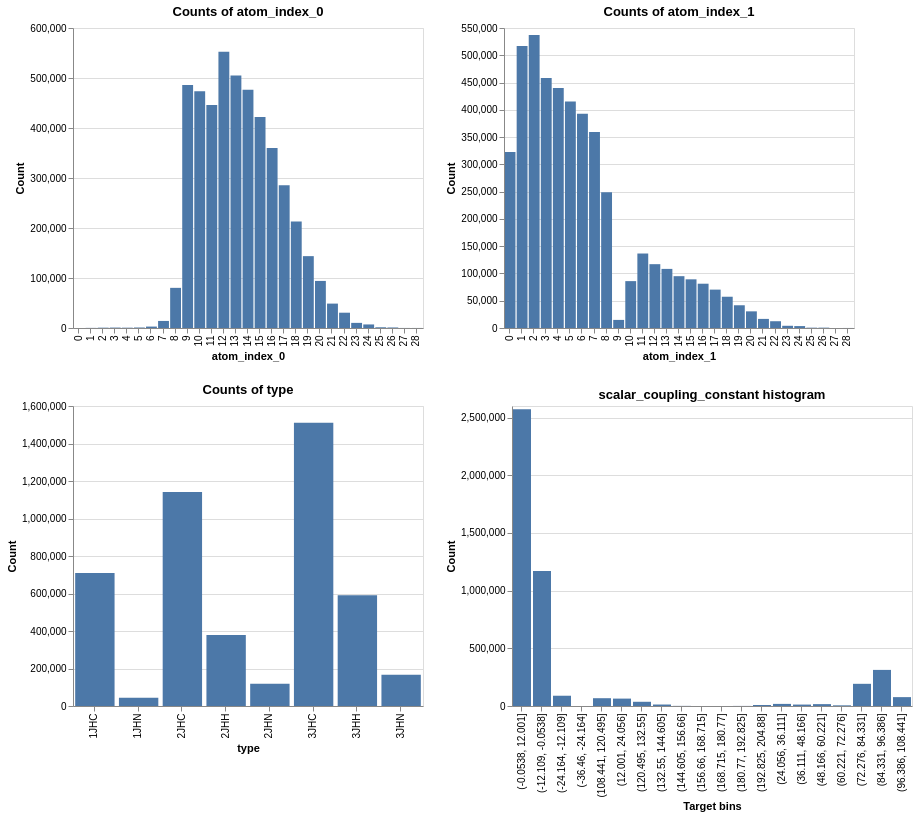

In [10]:
(chart1 | chart2) & (chart3 | chart4)

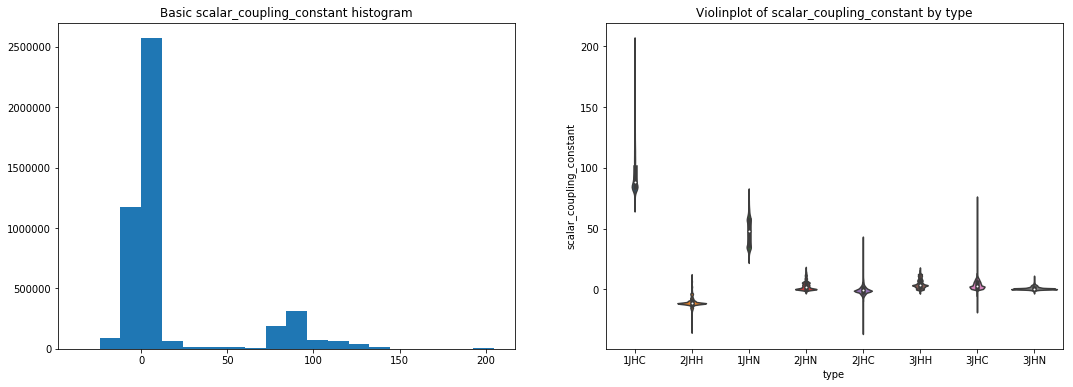

In [11]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

There are many interesting things here:

1. among first atoms there is a little number of atoms with index lower than 7 or higher than 24;
2. among second atoms there is a little number of atoms with index higher than 24. Also index with atom with index 9 in quite rare;
3. coupling types are unevenly distributed. There are 3 very popular, 3 quite rare and 2 with medium frequency;
4. target variable has a bimodal distribution;
5. different coupling types have really different values of target variable. Maybe it would make sense to build separate models for each of them;

In [13]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0        84.807599999999994  
1       -11.257000000000000  
2       -11.254799999999999  
3       -11.254300000000001  
4        84.807400000000001

In [14]:
structures.head()

molecule_name  atom_index atom             x             y             z
0  dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580  0.0080009958
1  dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176  0.0019761204
2  dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620  0.0002765748
3  dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140 -0.8766437152
4  dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440  0.9063972942

In [12]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df



In [15]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [16]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0          x_0           y_0           z_0  \
0        84.807599999999994      H  0.002150416 -0.0060313176  0.0019761204   
1       -11.257000000000000      H  0.002150416 -0.0060313176  0.0019761204   
2       -11.254799999999999      H  0.002150416 -0.0060313176  0.0019761204   
3       -11.254300000000001      H  0.002150416 -0.0060313176  0.0019761204   
4        84.807400000000001      H  1.011730843  1.4637511620  0.0002765748   

  atom_1           x_1          y_1           z_1  
0      C -0.0126981359  1.085804158  0.0080009958  
1      H  1.0117308430  1.463751162  0.0002765748  
2      H -0.5408150690  1.447526614 -0.8766437152  
3      H -0.5238136345  1.437932644  0.9063972942  
4      C -0.0126981359  1.085804158  0.0080009958

In [17]:
test.head()

id     molecule_name  atom_index_0  atom_index_1  type atom_0  \
0  4658147  dsgdb9nsd_000004             2             0  2JHC      H   
1  4658148  dsgdb9nsd_000004             2             1  1JHC      H   
2  4658149  dsgdb9nsd_000004             2             3  3JHH      H   
3  4658150  dsgdb9nsd_000004             3             0  1JHC      H   
4  4658151  dsgdb9nsd_000004             3             1  2JHC      H   

           x_0  y_0  z_0 atom_1           x_1  y_1  z_1  
0 -1.661638586  0.0  1.0      C  0.5995394918  0.0  1.0  
1 -1.661638586  0.0  1.0      C -0.5995394918  0.0  1.0  
2 -1.661638586  0.0  1.0      H  1.6616385860  0.0  1.0  
3  1.661638586  0.0  1.0      C  0.5995394918  0.0  1.0  
4  1.661638586  0.0  1.0      C -0.5995394918  0.0  1.0

In [18]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [19]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0          x_0           y_0           z_0  \
0        84.807599999999994      H  0.002150416 -0.0060313176  0.0019761204   
1       -11.257000000000000      H  0.002150416 -0.0060313176  0.0019761204   
2       -11.254799999999999      H  0.002150416 -0.0060313176  0.0019761204   
3       -11.254300000000001      H  0.002150416 -0.0060313176  0.0019761204   
4        84.807400000000001      H  1.011730843  1.4637511620  0.0002765748   

  atom_1           x_1          y_1           z_1               dist  \
0      C -0.0126981359  1.085804158  0.0080009958  1.091953059611900   
1      H  1.0117308430  1.463751162  0.0002765748  1.783119756038801   
2      H -0.5408150690  1.447526614 -0.8766437152  1.783147496403011   
3      H -0.5238136345  1.437932644  0.9063972942  1.783156685329616   
4      C -0.0126981359  1.085804158  0.0080009958  1.091951618581363   

              dist_x             dist_y             dist_z  
0  0.000220479493527  1.192104705778678  0.000036299123586  
1  1.019252638581502  2.160260537339124  0.000002888455246  
2  0.294811517901285  2.112830660517270  0.771972815509771  
3  0.276638182418367  2.085031922399566  0.817977659617770  
4  1.049454732810097  0.142843937832576  0.000059666679785

In [20]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [21]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0          x_0           y_0           z_0  \
0        84.807599999999994      H  0.002150416 -0.0060313176  0.0019761204   
1       -11.257000000000000      H  0.002150416 -0.0060313176  0.0019761204   
2       -11.254799999999999      H  0.002150416 -0.0060313176  0.0019761204   
3       -11.254300000000001      H  0.002150416 -0.0060313176  0.0019761204   
4        84.807400000000001      H  1.011730843  1.4637511620  0.0002765748   

  atom_1           x_1          y_1           z_1               dist  \
0      C -0.0126981359  1.085804158  0.0080009958  1.091953059611900   
1      H  1.0117308430  1.463751162  0.0002765748  1.783119756038801   
2      H -0.5408150690  1.447526614 -0.8766437152  1.783147496403011   
3      H -0.5238136345  1.437932644  0.9063972942  1.783156685329616   
4      C -0.0126981359  1.085804158  0.0080009958  1.091951618581363   

              dist_x             dist_y             dist_z type_0 type_1  
0  0.000220479493527  1.192104705778678  0.000036299123586      1    JHC  
1  1.019252638581502  2.160260537339124  0.000002888455246      2    JHH  
2  0.294811517901285  2.112830660517270  0.771972815509771      2    JHH  
3  0.276638182418367  2.085031922399566  0.817977659617770      2    JHH  
4  1.049454732810097  0.142843937832576  0.000059666679785      1    JHC

In [22]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')

In [23]:
train[f'molecule_type_dist_mean'] = train.groupby(['molecule_name', 'type'])['dist'].transform('mean')
test[f'molecule_type_dist_mean'] = test.groupby(['molecule_name', 'type'])['dist'].transform('mean')

In [24]:
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [36]:
train.to_csv('../cache/train1.csv', index=False)
test.to_csv('../cache/test1.csv', index=False)

In [25]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

In [26]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Tue Jun  4 20:28:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.77131	valid_1's l1: 1.8832
[2000]	training's l1: 1.61904	valid_1's l1: 1.80999
[3000]	training's l1: 1.51535	valid_1's l1: 1.77333
[4000]	training's l1: 1.4316	valid_1's l1: 1.74829
[5000]	training's l1: 1.36095	valid_1's l1: 1.73001
[6000]	training's l1: 1.29906	valid_1's l1: 1.71543
[7000]	training's l1: 1.24386	valid_1's l1: 1.7043
[8000]	training's l1: 1.19328	valid_1's l1: 1.69433
[9000]	training's l1: 1.14705	valid_1's l1: 1.68651
[10000]	training's l1: 1.10447	valid_1's l1: 1.67889
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 1.10447	valid_1's l1: 1.67889
Fold 2 started at Tue Jun  4 20:49:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.77035	valid_1's l1: 1.88423
[2000]	training's l1: 1.61875	valid_1's l1: 1.81285
[3000]	training's l1: 1.514	valid_1's l1: 1.77506
[4000]	training

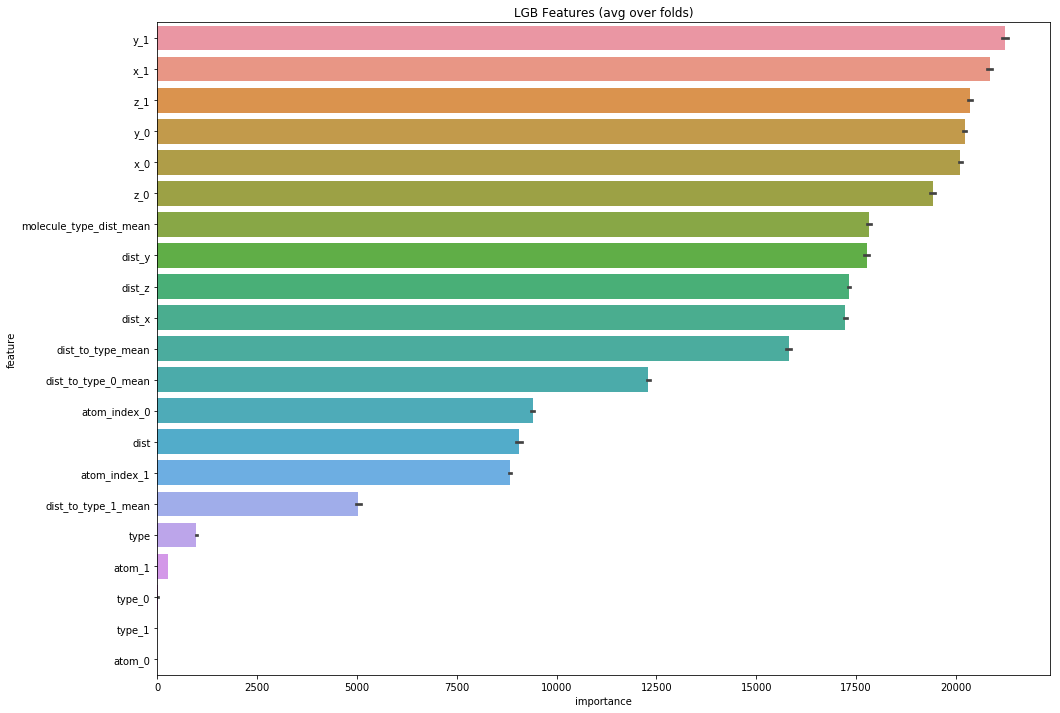

In [29]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 11,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=1000, early_stopping_rounds=200, n_estimators=10000)

In [30]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('../submissions/sub1.csv', index=False)
sub.head()

id  scalar_coupling_constant
0  4658147         6.904417203568204
1  4658148       193.406439896526365
2  4658149         3.573465412134901
3  4658150       194.067267112080032
4  4658151         6.075579482889720

In [33]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub1.csv -m ""

100%|██████████████████████████████████████| 63.9M/63.9M [00:18<00:00, 3.60MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 353 ms, sys: 198 ms, total: 551 ms
Wall time: 20.6 s


In [35]:
from time import sleep
sleep(10)
!kaggle competitions submissions -c champs-scalar-coupling

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub1.csv  2019-06-04 16:51:51  None         complete  0.299        None          
